## Gathered Notebook

This notebook was generated by the Gather Extension. The intent is that it contains only the code and cells required to produce the same results as the cell originally selected for gathering. Please note that the Python analysis is quite conservative, so if it is unsure whether a line of code is necessary for execution, it will err on the side of including it.

**Please let us know if you are satisfied with what was gathered [here](https://aka.ms/gatherfeedback).**

Thanks

In [4]:
import mne
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import scipy.stats as stats
data_dir = Path('data/chb-mit-2-subjects')

In [5]:
def info_to_df(info_path):
    """Loads summary text file from single subject from CHB-MIT dataset
    
    Splits text files into chunks (text separated by blank lines in summary file). Then parses
    each chunk to extract file/siezure information. Code could be modified to return channel
    info.
    
    Parameters
    ----------
    info_path : str
       Path to summary file (.txt)
        
    Returns
    -------
    df : pd.DataFrame
        Summary info in a dataframe
    """
    with open(info_path, 'r') as infile:
            info_string = infile.read()
    info_array = info_string.split('\n')
    chunked_list = []
    chunk=[]
    for line in info_array:
        if line:
            chunk.append(line)
        elif chunk: # this prevents empty chunks
            chunked_list.append(chunk)
            chunk=[]
    
    file_list = [x for x in chunked_list if 'File Name' in x[0]] # filter only files
    ds = []
    for file in file_list:
        d={}
        for f in file[:4]:
            string = f.split(': ')
            d.update({string[0].replace(' ','_').lower(): string[1]})
            
            
        d.update({'subject':d['file_name'].split('_')[0]})
        
        # read seizures to dict (can do any number of seizures)
        times = []
        for f in file[4:]:
            string = f.split(': ')
            sub = string[1].split(' ')
            times.append(sub[0])
        if times:
            times = np.reshape(times,(int(len(times)/2),2))
        d.update({'seizure_times':times})
        
        ds.append(d)
    return pd.DataFrame(ds)

In [6]:
def get_summaries(data_dir):
    """Loads all summary files into a dataframe.
    
    Parameters
    ----------
    data_dir : str
       Path to data CHB-MIT (str or Path object)
        
    Returns
    -------
    df_info : pd.DataFrame
        Summary info dataframe
    """
    
    files = glob.glob(str(data_dir) + "*/*/*.txt")
    dfs = []
    for f in files:
        
        if 'chb24' not in f: # skip odd summary for now
            df = info_to_df(f)
            
            #df["file_path"] = f
            dfs.append(df)
    df_info = pd.concat(dfs)
    df_info.reset_index(drop=True,inplace=True)
    return df_info
df_info = get_summaries(data_dir)

In [7]:
for i,row in df_info.loc[25:25].iterrows():
    path = data_dir / row.file_name.split('_')[0] /row.file_name
    raw = mne.io.read_raw_edf(path, exclude=['-', 'T8-P8', '.'], verbose=False, preload=True)

In [8]:
data, times = raw.get_data(return_times=True) # data: channel x time

In [9]:
epoch = df_info.seizure_times.loc[25][0]
fs = raw.info['sfreq']
s, e = (epoch.astype('int') * fs).astype(int)
ictal_labels = np.zeros(data.shape[1])
ictal_labels[s:e] = 1
win_length = 5
n_segments = int(data.shape[1]/(win_length*fs)) # duplicate from function below
y = np.reshape(ictal_labels,(n_segments,-1))
y = np.where(np.sum(y,axis=1)>0,1,0) # could change the 1st zero to threshold how many samples to count as siezure 

In [10]:
def make_stats_df(X,stat_label):
    """ turn stats array in DataFrame with stats_lable column names
    
    Args:
        X (ndarray): data matrix (segments x time)
        stat_label (string): name of the stat to append to col label
    Returns:
        df (pd.DataFrame)
    """
    df = pd.DataFrame(X, columns=[stat_label + '_' + x for x in raw.info['ch_names']])
    return df
def calc_segment_stats(raw,win_length=5):
    """Calculates various statistics for EEG signals.
    Args:
        raw (nme) TODO
        win_lenth (int): length of window for each segment (seconds)
    Returns:
        df_out (pd.DataFrame): segments x (channels * number of stats)
    """
    # get ndarray from raw object
    data, times = raw.get_data(return_times=True)
    # get info
    fs = raw.info['sfreq']
    n_segments = int(data.shape[1]/(win_length*fs))
    n_chan = raw.info["nchan"]
    D = np.reshape(data,(n_chan,n_segments,-1)) # channel x segment x time
    # calc stats for segments
    m = np.mean(D,axis=2).T
    v = np.var(D,axis=2).T
    s = stats.skew(D,axis=2).T
    k = stats.kurtosis(D,axis=2).T
    sd = np.std(D,axis = 2).T
    zerox = (np.diff(np.sign(D)) != 0).sum(axis=2).T # count sign changes/zero crossings
    max_min = (np.max(D,axis=2) - np.min(D,axis=2)).T # peak-to-peak voltage
    # make data frames
    stats_list = [m,v,s,k,sd,zerox,max_min]
    labels = ["mean","variance","skew","kurtosis","std","zerox","max-min"]
    df_out = pd.concat([make_stats_df(x,y) for x,y in zip(stats_list,labels)],axis=1)
    return df_out
df_stats = calc_segment_stats(raw,5)

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Text(0, 0.5, 'PC 2')

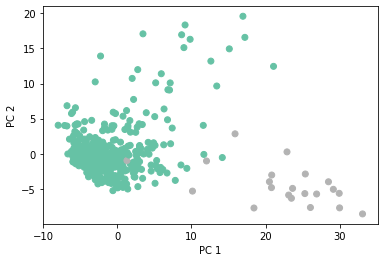

In [12]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA(svd_solver='auto',n_components=50))])
X = pipe.fit_transform(df_stats)
plt.scatter(X[:,0],X[:,1],c=y,cmap='Set2') # y = ictal_labels
plt.xlabel('PC 1')
plt.ylabel('PC 2')